# Table of Contents
 <p><div class="lev1"><a href="#Bayesian-Networks-Essays"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bayesian Networks Essays</a></div><div class="lev2"><a href="#Cancer-test"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cancer test</a></div><div class="lev3"><a href="#Definition"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Definition</a></div><div class="lev3"><a href="#Two-Cancer-Test"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Two Cancer Test</a></div><div class="lev3"><a href="#Conditional-Independent"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Conditional Independent</a></div><div class="lev2"><a href="#Happinnes-Hipothesys"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Happinnes Hipothesys</a></div><div class="lev2"><a href="#References"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>References</a></div>

# Bayesian Networks Essays

In [1]:
from IPython.display import HTML, display
from nxpd import draw
from functools import wraps
from itertools import permutations

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re

%matplotlib inline

In [2]:
Σ = sum

In [3]:
def auto_display(f):
    @wraps(f)
    def _f(self, *args, **kwargs):
        verbose = self.verbose
        self.verbose = False

        term = f(self, *args, **kwargs)
        
        self.verbose = verbose
        self.display(term)
        
        return self.values[term]
    return _f

In [4]:
def draw_graph(
    graph, labels=None
):
    # create networkx graph
    G = nx.DiGraph()
    G.graph['dpi'] = 120

    G.add_nodes_from(set([
        graph[k1][k2] 
        for k1 in range(len(graph)) 
        for k2 in range(len(graph[k1]))
    ]))
    G.add_edges_from(graph)
    return draw(G, show='ipynb')

In [5]:
def EX(ex, P):
    return eval(ex)

In [6]:
class BayesianNetework():
    """
    Some useful rules derived from [Kolgomorov Axioms]
    (https://en.wikipedia.org/wiki/Probability_axioms) 
    for random variables:
    
    """
    prior_list = set([])
    values = {}
    verbose = False
    display_formula = False
    
    def __init__(self, verbose: bool=False, display_formula: bool=False):
        self.verbose = verbose
        self.display_formula = display_formula
        self.values = {}
        self.prior_list = set([])
    
    def display(self, of: str):
        if self.verbose:
            print('P(%s)=%s' % (of, self.values[of]))
    
    def check(self, of: str):
        """
        
        """
        return of in self.values
    
    @auto_display
    def P(self, of: str):
        """
        
        """
        return of
    
    def prior(
        self, of: str=None, value: float=None
    ):
        """
        P(C): the prior probability (what we know before the evidence)
        """
        if not value is None:
            self.values[of] = value
            self.prior_list |= {of}
            
        return self.P(of)
    
    def likelihood(
        self, of: [str]=None, given: [str]=None, value: float=None
    ):
        """
        P(+|C): the likelihood of the data given the hypothesis
        """
        
        if isinstance(of, str):
            of = [of]
            
        if isinstance(given, str):
            given = [given]
        
        _of = '.'.join(of)
        for g in permutations(given, len(given)):
            _given = ','.join(g)
            term = '%s|%s' % (_of, _given)
            self.values[term] = value
            
        return self.P(term)

    def chain_rule():
        """
        Chain Rule: 
        P(A1,A2…An)=P(A1)P(A2|A1)…P(An|A1,A2…An−1)
        """
        pass
    
    @auto_display
    def p_joint(self, A: str, B: str):
        """
        
        """
        term = '%s,%s' % (A, B)
        self.values[term] = self.P(A) * self.P(B)
        
        return term
    
    @auto_display
    def p_total(self, of: [str], given: [str]):
        """
        Total Probability
        
        P(A|C) = ∑i P(A|C,Bi) * P(Bi|C)
        """
        # P(+1|+2)=P(+1|+2,C)P(C|+2)+P(+1|+2,¬C)P(¬C|+2)=…=0.2304
        P = self.P
        
        term = '%s|%s' % (of, given)
        exprs = []
        
        for prior in self.prior_list:
            if given.replace('!', '') in prior.replace('!', ''):
                continue
            if not self.check('%s|%s,%s' % (of, given, prior)):
                continue
                
            exprs.append(
                "P('%s|%s,%s') * P('%s|%s')" % (
                    of, given, prior, prior, given
                )
            )
        
        if self.display_formula:
            print('\nΣ', exprs)
            
        self.values[term] = Σ(map(lambda ex: EX(ex, P), exprs))
        
        return term
    
    @auto_display
    def p_marginal(self, of: str):
        """
        Bi∩Bj=∅,∑iBi=Ω:
        
        P(A) = ∑iP(A,Bi)
        
        """
        P = self.p_joint
        self.values[of] = sum([
            P('%s|%s' % (of, b), b) 
            for b in self.prior_list
        ])
        return of
    
    @auto_display
    def bayes_rules(self, of: [str], given: [str]):
        """
        
        P(A|B,C) = (P(B|A,C)*P(A|C))/P(B|C)
        
        Example:
        
        P(C|+) = (P(+|C)*P(C))/P(+)
        
        """
        P = self.P
        
        _of = '.'.join(of)
        _given = ','.join(given)
        
        _likelihood = '%s|%s' % (_given, _of)
        _prior = _of
        _evidence = _given
        
        term = ('%s|%s' % (_of, _given))
        
        self.values[term] = (
            P(_likelihood) * P(_prior)
        )/P(_evidence)
        
        return term
    
    @auto_display
    def conditional(self, of: str, given: str):
        """
        Conditional Probability:
        P(A,B)=P(B|A)P(A)=P(A|B)P(B)
        
        """
        P = self.P
        
        term = '%s|%s' % (of, given)
        self.values[term] = None
        
        return term
    
    @auto_display
    def conditional_independent(self, p1: str, p2: str):
        """
        
        """
        self.values[p1] = self.P(p2)
        return p1
    
    @auto_display
    def evidence(self, of: str):
        """
        P(+): e.g. the evidence 
        the marginal probability of the test is positive
        
        """
        self.values[of] = self.p_marginal(of)
        return of
    
    @auto_display
    def proportional_posterior(self, of: [str], given: [str]):
        """
        Posterior probability ∝ Likelihood × Prior probability
        
        """
        P = self.P
        p = {}
        
        _of = '.'.join(of)
        _given = ','.join(given)
        
        term = '%s|%s' % (_of, _given)
        
        for i, _prior in enumerate(self.prior_list):
            _p_likelihood = []
            for _given in given:
                _likelihood = '%s|%s' % (_given, _prior)
                _p_likelihood.append(P(_likelihood))
                
            p[_prior] = np.prod(np.array(_p_likelihood)) * P(_prior)
        
        self.values[term] = p[_of]/sum(p.values())
        return term
        
    @auto_display
    def posterior(self, of: [str], given: [str]):
        """
        P(C|+): the posterior probability, the new belief after the evidence
        is processed, using Bayes’ rule.
        
        The posterior probability can be written in the memorable form as

        Posterior probability ∝ Likelihood × Prior probability
        
        """
        
        if isinstance(of, str):
            of = [of]
            
        if isinstance(given, str):
            given = [given]
        
        _of = '.'.join(of)
        _given = ','.join(given)
        
        term = '%s|%s' % (_of, _given)
        
        if _given in self.values:
            self.values[term] = self.bayes_rules(of=of, given=given)
        else:
            self.values[term] = self.proportional_posterior(
                of=of, given=given
            )
        
        return term
    

## Cancer test

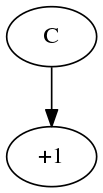

In [7]:
# Graphs
graph = [('C', '+1')]
draw_graph(graph)

### Definition

$
P(C) = 0.01\\
P(\neg C) = 0.99\\
P(+|C) = 0.9\\
P(-|C) = 0.1\\
P(+|\neg C) = 0.2\\
P(-|\neg C) = 0.8
$

In [8]:
bnet = BayesianNetework(verbose=True)

# Prior Probability
print('\nPrior Probability')
P = bnet.prior
P('C', 0.01)
P('!C', 1-P('C'))

# likelihood of the data given the hypothesis
print('\nlikelihood of the data given the hypothesis')
P = bnet.likelihood
P(of='+', given='C', value=0.9)
P(of='-', given='C', value=0.1)
P(of='+', given='!C', value=0.2)
P(of='-', given='!C', value=0.8)

print('\nEvidence')
P = bnet.evidence
P('+')
P('-')

print('\nThe posterior probability')
P = bnet.posterior
P(of='C', given='+')
P(of='C', given='-')
P(of='!C', given='+')
P(of='!C', given='-')


Prior Probability
P(C)=0.01
P(C)=0.01
P(!C)=0.99

likelihood of the data given the hypothesis
P(+|C)=0.9
P(-|C)=0.1
P(+|!C)=0.2
P(-|!C)=0.8

Evidence
P(+)=0.20700000000000002
P(-)=0.793

The posterior probability
P(C|+)=0.043478260869565216
P(C|-)=0.0012610340479192938
P(!C|+)=0.9565217391304347
P(!C|-)=0.9987389659520807


0.9987389659520807

### Two Cancer Test

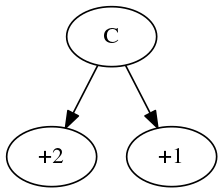

In [9]:
# Graphs

graph = [('C', '+1'), ('C', '+2')]
draw_graph(graph)

In [10]:
print('\nThe posterior probability')
P = bnet.posterior
P(of='C', given=['+', '+'])
P(of='!C', given=['+', '+'])
P(of='C', given=['+', '-'])
# P(of=['C', '+'], given=['+'])


The posterior probability
P(C|+,+)=0.169811320755
P(!C|+,+)=0.830188679245
P(C|+,-)=0.00564971751412


0.005649717514124292

### Conditional Independent

In [11]:
P = bnet.conditional_independent
P('+|+,C', '+|C')
P('+|+,!C', '+|!C')

P = bnet.p_total
P(of='+', given='+')

P(+|+,C)=0.9
P(+|+,!C)=0.2
P(+|+)=0.23043478260869565


0.23043478260869565

## Happinnes Hipothesys

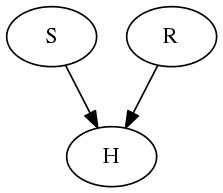

In [12]:
# Graphs

graph = [('S', 'H'), ('R', 'H')]
draw_graph(graph)

In [13]:
bnet = BayesianNetework(verbose=True, display_formula=True)

display(HTML('<h3>PRIOR PROBABILITY</h3>'))
P = bnet.prior

P('S', 0.7)
P('!S', 0.3)
P('R', 0.01)
P('!R', 0.99)

P(S)=0.7
P(!S)=0.3
P(R)=0.01
P(!R)=0.99


0.99

In [14]:
display(HTML('<h3>JOINT PROBABILITY</h3>'))
P = bnet.p_joint

P('S', 'R')
P('S', '!R')
P('!S', 'R')
P('!S', '!R')

P(S,R)=0.006999999999999999
P(S,!R)=0.693
P(!S,R)=0.003
P(!S,!R)=0.297


0.297

In [15]:
display(HTML('<h3>LIKELIHOOD PROBABILITY</h3>'))
P = bnet.likelihood

P(of='H', given=['S', 'R'], value=1)
P(of='H', given=['!S', 'R'], value=0.9)
P(of='H', given=['S', '!R'], value=0.7)
P(of='H', given=['!S', '!R'], value=0.1)

P(H|R,S)=1
P(H|R,!S)=0.9
P(H|!R,S)=0.7
P(H|!R,!S)=0.1


0.1

In [16]:
display(HTML('<h3>CONDITIONAL INDEPENDENCE</h3>'))
P = bnet.conditional_independent

P('R|S', 'R')
P('R|!S', 'R')
P('!R|S', '!R')
P('!R|!S', '!R')
P('S|R', 'S')
P('S|!R', 'S')
P('!S|R', '!S')
P('!S|!R', '!S')

P(R|S)=0.01
P(R|!S)=0.01
P(!R|S)=0.99
P(!R|!S)=0.99
P(S|R)=0.7
P(S|!R)=0.7
P(!S|R)=0.3
P(!S|!R)=0.3


0.3

In [20]:
display(HTML('<h3>EVIDENCE</h3>'))

P = bnet.p_total
P(of='H', given='S')
P(of='H', given='R')
P(of='H', given='!S')
P(of='H', given='!R')
#P(of='R', given=['H', 'S'])

P = bnet.evidence
#P('H')


Σ ["P('H|S,R') * P('R|S')", "P('H|S,!R') * P('!R|S')"]

Σ ["P('H|R,!S') * P('!S|R')", "P('H|R,S') * P('S|R')"]

Σ ["P('H|!S,R') * P('R|!S')", "P('H|!S,!R') * P('!R|!S')"]

Σ ["P('H|!R,!S') * P('!S|!R')", "P('H|!R,S') * P('S|!R')"]


In [21]:
"""
display(HTML('<h3>POSTERIOR PROBABILITY</h3>'))

P = bnet.posterior
P(of='R', given=['H', 'S'])
"""
None

## References

Bayesian Networks - João Neto - December 2013
http://www.di.fc.ul.pt/~jpn/r/bayesnets/bayesnets.html

Creating Network Graphs with Python
https://www.udacity.com/wiki/creating-network-graphs-with-python
